### Setup

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
import math
import timm
from math import ceil
from matplotlib import colormaps
import PIL
import random
from IPython.display import display, clear_output
import kornia
from prettytable import PrettyTable

try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.models as models
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")
    
    
from utils.models.EfficientNet import EfficientNet
from utils.models.TinyVGG import TinyVGG
from utils.models.ResNet import ResNet
from utils.models.VGG16 import VGG16
from utils.models.EfficientNetb1 import EfficientNet_b1
from utils.pipelines.image_transformation import image_transformer 

# Scikit learn accuracy score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

torchvision.disable_beta_transforms_warning()

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


In [51]:
# Load config
config = load_config(eval(os.environ["COLAB"]))

In [52]:
device = torch.device("cpu")

### Get data

In [53]:
def prepare_data(img_size='S', shuffle=False, alt_augmentation=False, return_just_test_data = False):
    # Target Transformations (Removing the c from the target)
    target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))
    
    # Image augmentations
    image_augmentations = image_transformer(img=None, size=img_size, alt_augmentation=alt_augmentation, return_augmentation_object=True)
    
    # Creating the dataset
    test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=image_augmentations if not return_just_test_data else None, 
                            target_transform=target_transform)
    
    if return_just_test_data:
        return test_data
    
    # Creating the dataloader
    test_loader = DataLoader(test_data, 
                            batch_size=32, 
                            shuffle=shuffle)
    
    return test_loader, test_data

#### Load Models

In [54]:
# Tiny VGG model
# Path and directory files
TinyVGG_path = os.path.join(config['outputs']['path'], 'TinyVGG_500k')
TinyVGG_file = 'TinyVGG_500k_final.pt'

# initalize model
tinyvgg = TinyVGG()

# Load parameters from last model
tinyvgg.load_state_dict(torch.load(os.path.join(TinyVGG_path, TinyVGG_file)))
tinyvgg = tinyvgg.eval()

# print num of parameters
print(f"Loaded TinyVGG, with {sum(p.numel() for p in tinyvgg.parameters()):,} parameters")

Loaded TinyVGG, with 534,954 parameters


In [55]:
# EfficientNet model
# Load model
efficient = EfficientNet()

# Load parameters from last model
efficient.load_state_dict(torch.load(os.path.join(config['outputs']['path'], 'EfficientNet_after_CV', 'EfficientNet_final.pt'), map_location=torch.device('cpu')))
efficient = efficient.eval()

# print num of parameters
print(f"Loaded EfficientNetb0, with {sum(p.numel() for p in efficient.parameters()):,} parameters")

Loaded EfficientNetb0, with 4,020,358 parameters


In [56]:
# EfficientNet b1 model - pretrained 
# Load model
efficientb1 = EfficientNet_b1('outputs/EfficientNet/efficientnet_b1_94.pt')
efficientvb1 = efficientb1.eval()

# print num of parameters
print(f"Loaded EfficientNetb1, with {sum(p.numel() for p in efficientb1.parameters()):,} parameters")

Loaded EfficientNetb1, with 6,525,994 parameters


In [57]:
# Resnet model - pretrained 
# Load model
resnet = ResNet('outputs/ResNet/ResNet_v2_20240103_013959_epoch_14_highest_acc.pt')
resnet = resnet.eval()

# print num of parameters
print(f"Loaded ResNet, with {sum(p.numel() for p in resnet.parameters()):,} parameters")

Loaded ResNet, with 11,182,666 parameters


In [58]:
# vgg16 model - pretrained 
# Load model
vgg16 = VGG16('outputs/VGG16/VGG16_v3_20231229_183229_epoch_10.pt')
vgg16 = vgg16.eval()

# print num of parameters
print(f"Loaded VGG16, with {sum(p.numel() for p in vgg16.parameters()):,} parameters")

Loaded VGG16, with 135,311,946 parameters


## Run Test

#### Vanilla Test

In [59]:
def test(model, 
         device,
         img_size='L_SQUARED',
         alt_augmentation=None):
    """Test loop"""
    print('Starting test loop')
    # Prepare data
    test_loader, _ = prepare_data(img_size=img_size, alt_augmentation=alt_augmentation)

    # Setup test accuracy
    test_acc = 0
    
    # Setup lists for storing images, classes and predictions
    predictions = []
    predictions_argmax = []
    
    # Set model to eval
    model = model.eval()
    
    # Sent model to device
    model = model.to(device)
    
    print('Starting loop through test data...')
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(test_loader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data

            imgs, labels  = imgs.float().to(device), labels.to(device)

            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Done. Accuracy {test_acc / len(test_loader)}')
    return predictions, predictions_argmax

In [60]:
print('TinyVGG Test')
test_prediction_tiny = test(tinyvgg, device, img_size='S')

TinyVGG Test
Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.8050656392149729


In [49]:
print('EfficientNet from scratch test')
test_prediction_efficient = test(efficient, device, img_size='L_SQUARED', alt_augmentation=T.RandomHorizontalFlip(p=.5))

EfficientNet from scratch test
Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.8056506849315068


In [50]:
print('EfficientNetb1 pretrained test')
test_prediction_efficientb1 = test(efficientb1, device, img_size='L_SQUARED')

EfficientNetb1 pretrained test
Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.930636415742848


In [13]:
print('ResNet pretrained test')
test_prediction_resnet = test(resnet, device, img_size='L_SQUARED')

ResNet pretrained test
Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.868792808219178


In [42]:
print('VGG16 pretrained test')
test_prediction_efficient = test(vgg16, device, img_size='L_SQUARED')

VGG16 pretrained test
Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.8948915527291494


# Simulated real life: Sequential Predictions

In [100]:
# Extract test data
test_data = prepare_data(return_just_test_data=True)

# Sort the data based on subject, target and the image, as images are taken continuously from one frame
test_data.metadata = test_data.metadata.sort_values(by=['subject', 'target','img'])
test_data.img_labels = test_data.metadata[['img','classname', 'img_path']]

In [62]:
def predict_image(image_tensor, model, device, alt_augmentation = False, img_size='L_SQUARED'):
    # Function to get the predictions from the test data
    
    # Transform image
    frame = image_transformer(image_tensor, alt_augmentation=alt_augmentation, size=img_size)
    
    # Batch image
    frame = frame.unsqueeze(0)
    
    # Sent to device
    frame.to(device)
    
    # Predict
    model = model.eval()
    with torch.no_grad():
        # Get start time to compute inference time
        time_start = time.time()
        
        # Predict
        prediction = model(frame.to(device))
        
        # Get inference time
        time_final = time.time() - time_start
    
    return prediction, time_final
    

In [63]:
def sequential_image_predictor(model, test_data, image_size, weighted_prediction, alt_augmentation=False, device=device):
    # Function to sequentially predict images
    print('Starting loop through test data...')
    
    # Setup lists for storing images, classes and predictions
    classes = []
    predictions_argmax = []
    weighted_predictions = []
    inference_times = []
    
    # Sent model to device
    model = model.to(device)
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(test_data):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            classes.append(labels.cpu().numpy())
            
            # Predict
            prediction, inference_time = predict_image(imgs, model, device, img_size=image_size, alt_augmentation=alt_augmentation)
            weighted_predictions.append(weighted_prediction(prediction))
            predictions_argmax.append(prediction.argmax(1).cpu().numpy())
            inference_times.append(inference_time)
            
            # Print progress
            if i % 1000 == 0 and i != 0:
                print(f'Predicted {i} images, with an average inference time of {np.mean(inference_times):.5f} seconds or {1/np.mean(inference_times):.2f} images pr. second')
            
    # Return test accuracy
    print(f'Test Done. Predicted {len(test_data)} images, with an average inference time of {np.mean(inference_times)}')
    return classes, predictions_argmax, weighted_predictions, inference_times

In [64]:
def unpack_results(results, confusion_matrix_normalize = 'true', confusion_matrix_labels = config['dataset']['class_mapping'].values(), omit_talking_to_passenger = False):
    # Helper function to unpack results from sequential_image_predictor
    
    # Unpack results
    classes, predictions_argmax, _, inference_times = results
    
    # Flatten lists
    try:
        predictions_argmax = np.concatenate(predictions_argmax)
    except:
        pass
    
    # If omit talking to passenger is specified, it will be changed into safe driving.
    if omit_talking_to_passenger:
        classes = np.where(np.array(classes) == 9, 0, np.array(classes))
        predictions_argmax = np.where(predictions_argmax == 9, 0, predictions_argmax)

    # Create a table
    table = PrettyTable()
    table.field_names = ["Measure", "Result"]
    table.add_row(["Average inference time", f'{round(np.mean(inference_times), 5)} ({round(1/np.mean(inference_times))} fps)'])
    table.add_row(["Accuracy", f'{round(np.mean(classes == predictions_argmax),5)}'])
    table.add_row(["F1 score", f'{round(f1_score(classes, predictions_argmax, average="macro"),5)}'])
    table.add_row(["Precision score", f'{round(precision_score(classes, predictions_argmax, average="macro"), 5)}'])
    table.add_row(["Recall score", f'{round(recall_score(classes, predictions_argmax, average="macro"), 5)}'])
    
    # Print table
    print(table)
    
    # Make confusion matrix
    cm = confusion_matrix(classes, predictions_argmax, normalize=confusion_matrix_normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(confusion_matrix_labels)[:-1] if omit_talking_to_passenger else list(confusion_matrix_labels))

    disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical')

### Sequential Prediction for Models

**TinyVGG**

In [67]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
tiny_results = sequential_image_predictor(tinyvgg, test_data, 'S', weighted_predictor)

Starting loop through test data...
Predicted 1000 images, with an average inference time of 0.00346 seconds or 288.73 images pr. second
Predicted 2000 images, with an average inference time of 0.00353 seconds or 283.46 images pr. second
Predicted 3000 images, with an average inference time of 0.00352 seconds or 283.89 images pr. second
Predicted 4000 images, with an average inference time of 0.00354 seconds or 282.44 images pr. second
Test Done. Predicted 4670 images, with an average inference time of 0.0035707718810381677


+------------------------+-------------------+
|        Measure         |       Result      |
+------------------------+-------------------+
| Average inference time | 0.00357 (280 fps) |
|        Accuracy        |      0.80514      |
|        F1 score        |      0.79054      |
|    Precision score     |       0.8205      |
|      Recall score      |      0.79358      |
+------------------------+-------------------+


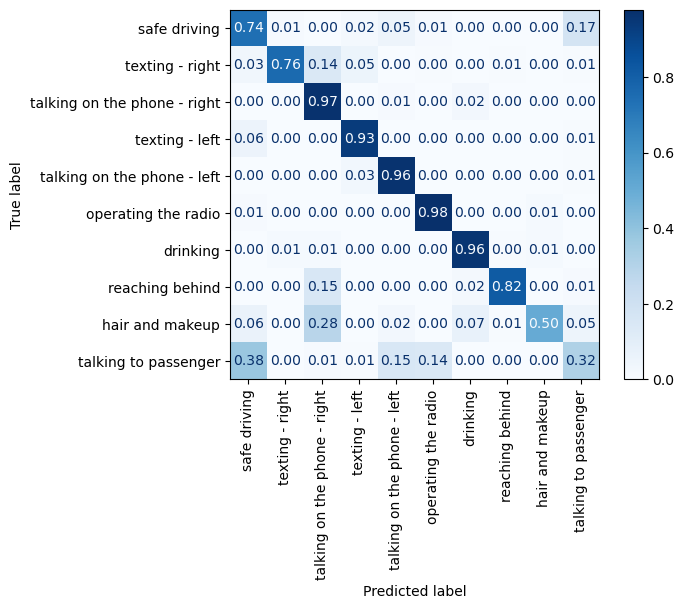

In [68]:
# Display tiny results
unpack_results(tiny_results)

+------------------------+------------------+
|        Measure         |      Result      |
+------------------------+------------------+
| Average inference time | 0.0021 (475 fps) |
|        Accuracy        |     0.86039      |
|        F1 score        |     0.85387      |
|    Precision score     |     0.88128      |
|      Recall score      |     0.85374      |
+------------------------+------------------+


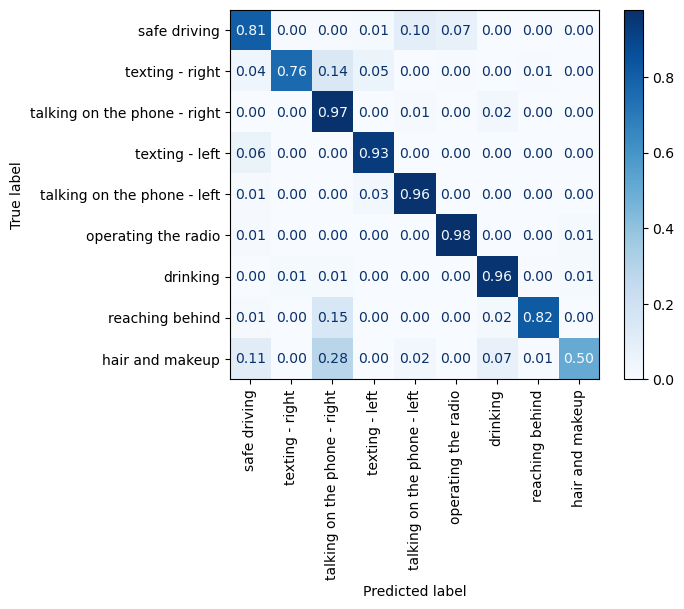

In [22]:
# Display tiny results without talking to passenger
unpack_results(tiny_results, omit_talking_to_passenger=True)

**EfficinetNet from Scratch**

In [23]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
efficient_results = sequential_image_predictor(efficient, test_data, 'L_SQUARED', weighted_predictor)

Starting loop through test data...
Predicted 1000 images, with an average inference time of 0.02182 seconds or 45.82 images pr. second
Predicted 2000 images, with an average inference time of 0.01949 seconds or 51.30 images pr. second
Predicted 3000 images, with an average inference time of 0.01869 seconds or 53.51 images pr. second
Predicted 4000 images, with an average inference time of 0.01829 seconds or 54.69 images pr. second
Test Done. Predicted 4670 images, with an average inference time of 0.018099585794534623


+------------------------+-----------------+
|        Measure         |      Result     |
+------------------------+-----------------+
| Average inference time | 0.0181 (55 fps) |
|        Accuracy        |     0.80942     |
|        F1 score        |     0.78755     |
|    Precision score     |     0.81256     |
|      Recall score      |     0.80209     |
+------------------------+-----------------+


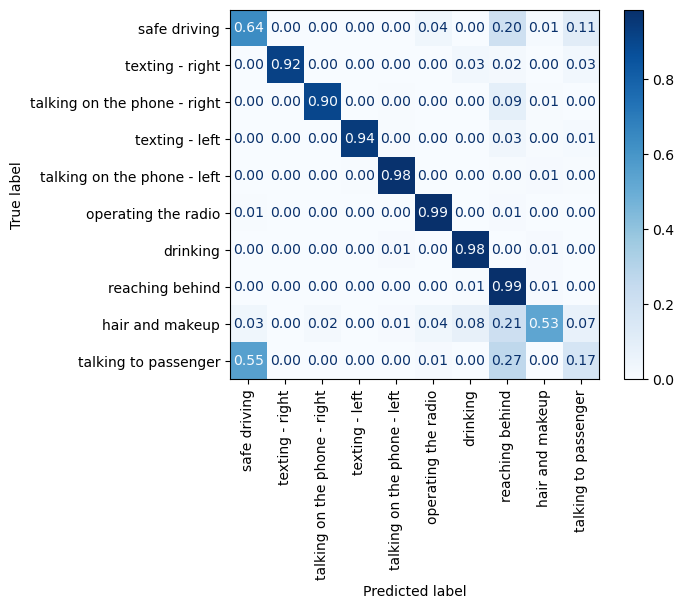

In [24]:
unpack_results(efficient_results)

+------------------------+------------------+
|        Measure         |      Result      |
+------------------------+------------------+
| Average inference time | 0.01727 (58 fps) |
|        Accuracy        |     0.86981      |
|        F1 score        |     0.86696      |
|    Precision score     |     0.89493      |
|      Recall score      |     0.87633      |
+------------------------+------------------+


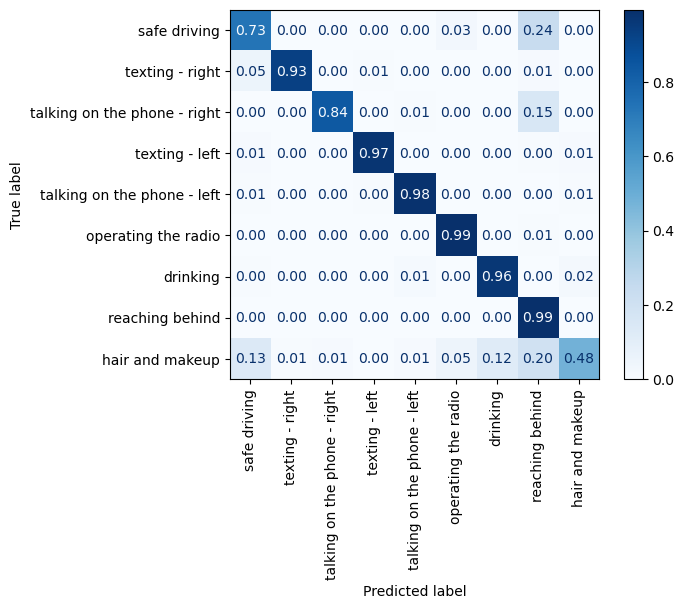

In [25]:
# Testing results if talking to passenger was omitted 
unpack_results(efficient_results, omit_talking_to_passenger=True)

**EfficinetNetB1 Pretrained**

In [97]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
efficientb1_results = sequential_image_predictor(efficientb1, tet, 'L_SQUARED', weighted_predictor)

Starting loop through test data...
Test Done. Predicted 50 images, with an average inference time of 0.5641551589965821


+------------------------+------------------+
|        Measure         |      Result      |
+------------------------+------------------+
| Average inference time | 0.02363 (42 fps) |
|        Accuracy        |     0.93062      |
|        F1 score        |     0.92876      |
|    Precision score     |     0.92938      |
|      Recall score      |     0.92871      |
+------------------------+------------------+


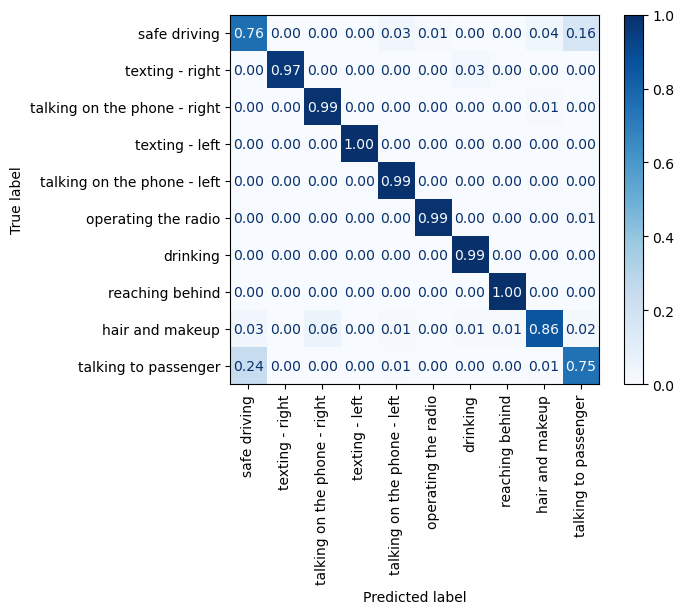

In [27]:
unpack_results(efficientb1_results)

+------------------------+------------------+
|        Measure         |      Result      |
+------------------------+------------------+
| Average inference time | 0.02363 (42 fps) |
|        Accuracy        |     0.97109      |
|        F1 score        |      0.9698      |
|    Precision score     |     0.96959      |
|      Recall score      |     0.97047      |
+------------------------+------------------+


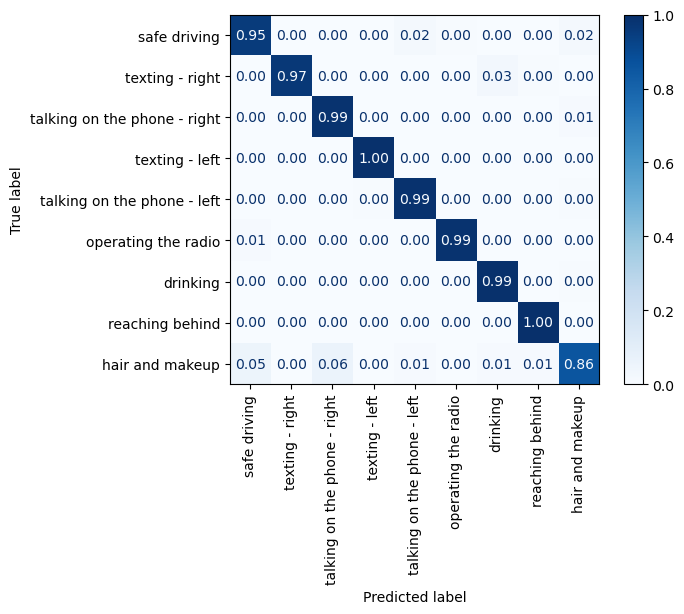

In [28]:
# Testing results if talking to passenger was omitted 
unpack_results(efficientb1_results, omit_talking_to_passenger=True)

**ResNet**

In [29]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
resnet_results = sequential_image_predictor(resnet, 
                                            test_data, 
                                            'L_SQUARED', 
                                            weighted_predictor) 

Starting loop through test data...
Predicted 1000 images, with an average inference time of 0.00605 seconds or 165.31 images pr. second
Predicted 2000 images, with an average inference time of 0.00557 seconds or 179.38 images pr. second
Predicted 3000 images, with an average inference time of 0.00539 seconds or 185.49 images pr. second
Predicted 4000 images, with an average inference time of 0.00535 seconds or 186.86 images pr. second
Test Done. Predicted 4670 images, with an average inference time of 0.0053982018913906185


+------------------------+------------------+
|        Measure         |      Result      |
+------------------------+------------------+
| Average inference time | 0.0054 (185 fps) |
|        Accuracy        |     0.86874      |
|        F1 score        |     0.86031      |
|    Precision score     |     0.86027      |
|      Recall score      |     0.86926      |
+------------------------+------------------+


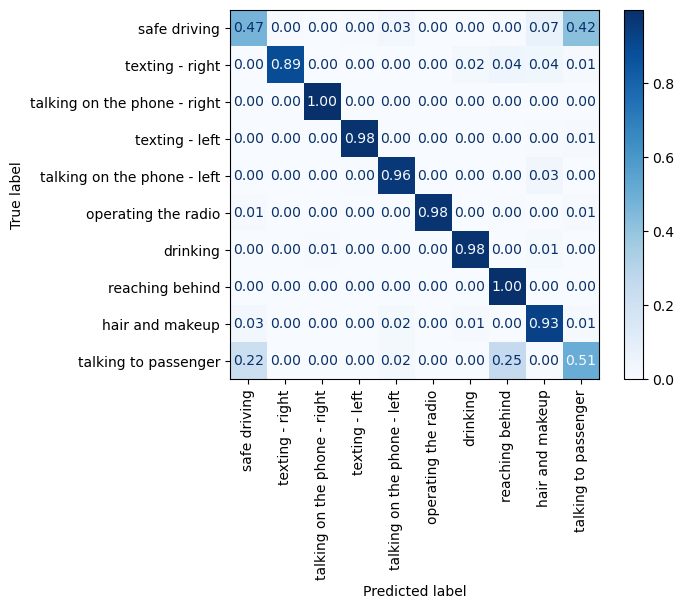

In [30]:
unpack_results(resnet_results)

+------------------------+------------------+
|        Measure         |      Result      |
+------------------------+------------------+
| Average inference time | 0.0054 (185 fps) |
|        Accuracy        |     0.93319      |
|        F1 score        |      0.9351      |
|    Precision score     |     0.93118      |
|      Recall score      |     0.94684      |
+------------------------+------------------+


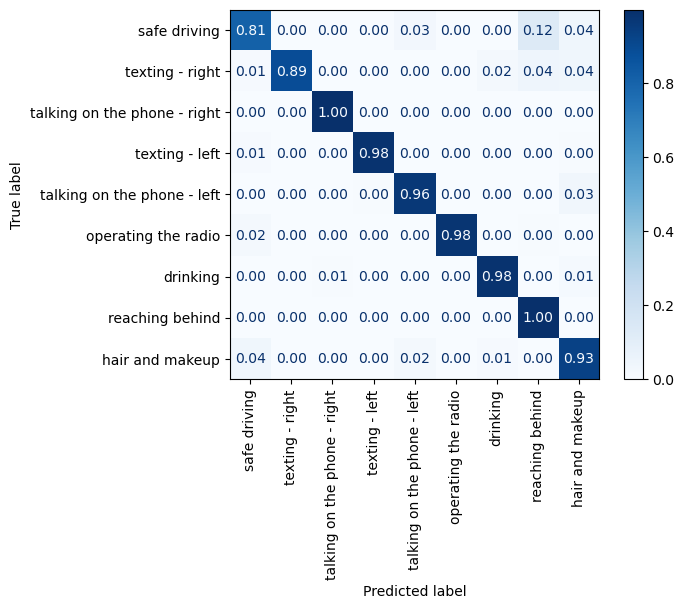

In [31]:
# Outpacking result with talking to passenger omitted
unpack_results(resnet_results, omit_talking_to_passenger=True)

**VGG16**

In [69]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
vgg16_results = sequential_image_predictor(vgg16, test_data, 'L_SQUARED', weighted_predictor)

Starting loop through test data...


Predicted 1000 images, with an average inference time of 0.06388 seconds or 15.65 images pr. second
Predicted 2000 images, with an average inference time of 0.06523 seconds or 15.33 images pr. second
Predicted 3000 images, with an average inference time of 0.06620 seconds or 15.11 images pr. second
Predicted 4000 images, with an average inference time of 0.06644 seconds or 15.05 images pr. second
Test Done. Predicted 4670 images, with an average inference time of 0.06644069939149778


+------------------------+------------------+
|        Measure         |      Result      |
+------------------------+------------------+
| Average inference time | 0.06644 (15 fps) |
|        Accuracy        |     0.89486      |
|        F1 score        |     0.88885      |
|    Precision score     |     0.88913      |
|      Recall score      |     0.89373      |
+------------------------+------------------+


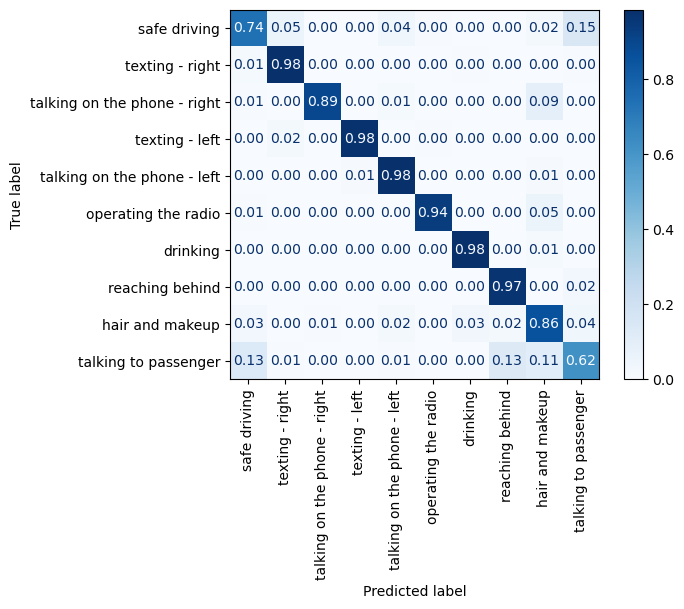

In [70]:
unpack_results(vgg16_results) #, confusion_matrix_labels=[f'c{i}' for i in range(10)])

+------------------------+-------------------+
|        Measure         |       Result      |
+------------------------+-------------------+
| Average inference time | 0.00271 (369 fps) |
|        Accuracy        |      0.92313      |
|        F1 score        |      0.92386      |
|    Precision score     |      0.91943      |
|      Recall score      |       0.9332      |
+------------------------+-------------------+


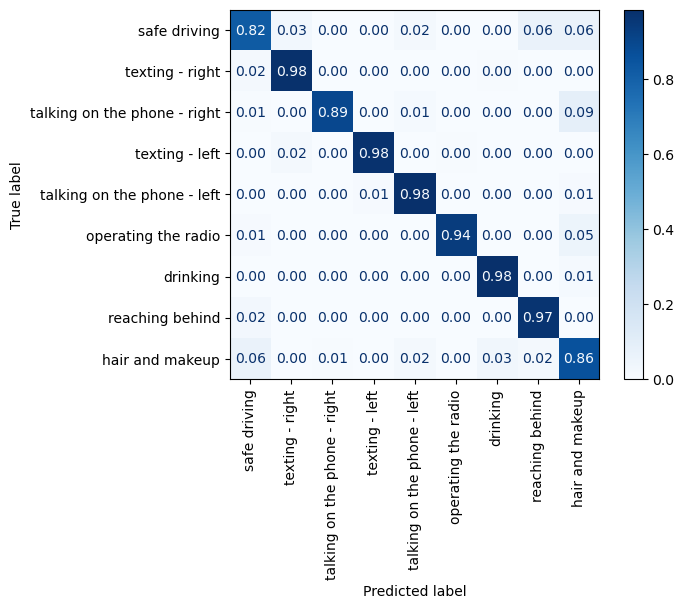

In [30]:
# Testing results if talking to passenger was omitted
unpack_results(vgg16_results, omit_talking_to_passenger=True)

#### Accuracy x Compute

In [35]:
# Plotting accuracy against fps

# Extracting inference and accuracy
classes, predictions_argmax_tiny, _, inference_times_tiny = tiny_results
predictions_argmax_tiny = np.array(predictions_argmax_tiny).flatten()

classes, predictions_argmax_efficient, _, inference_times_efficient = efficient_results
predictions_argmax_efficient = np.array(predictions_argmax_efficient).flatten()

classes, predictions_argmax_efficientb1, _, inference_times_efficientb1 = efficientb1_results
predictions_argmax_efficientb1 = np.array(predictions_argmax_efficientb1).flatten()

classes, predictions_argmax_resnet, _, inference_times_resnet = resnet_results
predictions_argmax_resnet = np.array(predictions_argmax_resnet).flatten()

classes, predictions_argmax_vgg, _, inference_times_vgg16 = vgg16_results
predictions_argmax_vgg = np.array(predictions_argmax_vgg).flatten()

classes = np.array(classes)

# function for computing accuracy
accuracy = lambda x: round(np.mean(x == classes),5)

accuracies = [accuracy(prediction) for prediction in (predictions_argmax_tiny, predictions_argmax_efficient, predictions_argmax_efficientb1, predictions_argmax_resnet, predictions_argmax_vgg)]
fps = [round(1/np.mean(inference_time),2) for inference_time in (inference_times_tiny, inference_times_efficient, inference_times_efficientb1, inference_times_resnet, inference_times_vgg16)]

Text(0.5, 1.0, 'Accuracy vs. FPS')

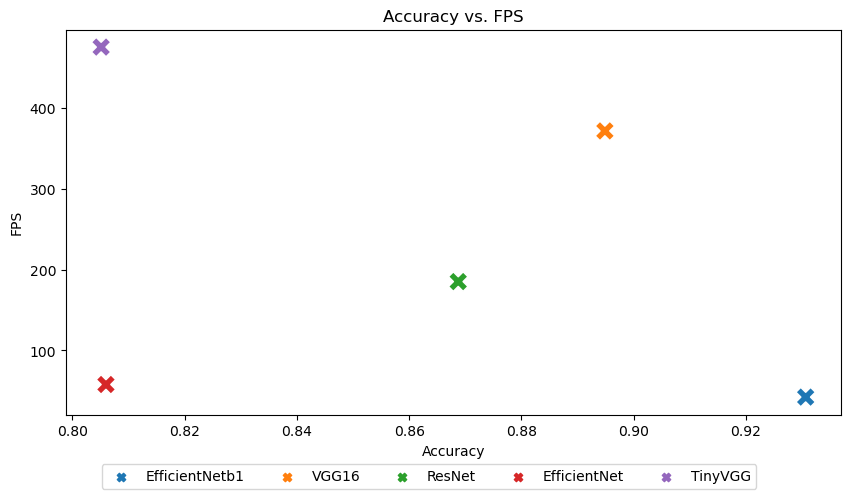

In [45]:
# Plotting Results
fig, axs = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=pd.DataFrame({'Model': ['TinyVGG', 'EfficientNet', 'EfficientNetb1', 'ResNet', 'VGG16'], 'Accuracy': accuracies, 'FPS': fps}).sort_values(by='Accuracy', ascending=False), x='Accuracy', y='FPS', hue='Model', style='Model', markers=['X', 'X', 'X', 'X', 'X'], s=200, ax=axs, palette='tab10', legend='brief')
axs.legend(bbox_to_anchor=(.9, -.11), ncol=5, frameon=True)
axs.set_title('Accuracy vs. FPS')

### Applying Random Hortizontal Flip

In [34]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
tiny_results = sequential_image_predictor(tinyvgg, test_data, 'S', weighted_predictor, alt_augmentation=T.RandomRotation(30))

Starting loop through test data...
Predicted 1000 images, with an average inference time of 0.00220 seconds or 455.29 images pr. second
Predicted 2000 images, with an average inference time of 0.00204 seconds or 489.71 images pr. second
Predicted 3000 images, with an average inference time of 0.00199 seconds or 501.55 images pr. second
Predicted 4000 images, with an average inference time of 0.00197 seconds or 507.66 images pr. second
Test Done. Predicted 4670 images, with an average inference time of 0.0019611328521173055


+------------------------+-------------------+
|        Measure         |       Result      |
+------------------------+-------------------+
| Average inference time | 0.00196 (510 fps) |
|        Accuracy        |      0.74325      |
|        F1 score        |       0.7313      |
|    Precision score     |      0.74084      |
|      Recall score      |      0.73467      |
+------------------------+-------------------+


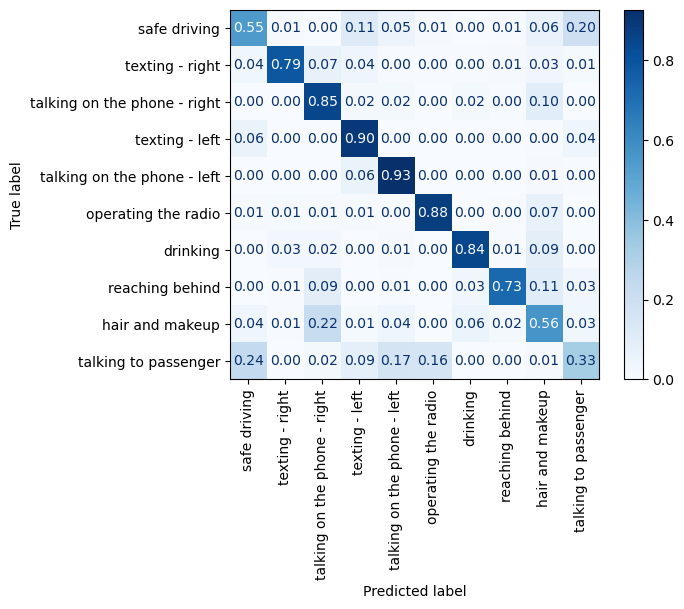

In [35]:
unpack_results(tiny_results)

In [31]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
vgg16_results = sequential_image_predictor(vgg16, test_data, 'L_SQUARED', weighted_predictor, alt_augmentation=T.RandomRotation(30))

Starting loop through test data...
Predicted 1000 images, with an average inference time of 0.00287 seconds or 348.55 images pr. second
Predicted 2000 images, with an average inference time of 0.00289 seconds or 346.27 images pr. second
Predicted 3000 images, with an average inference time of 0.00283 seconds or 353.13 images pr. second
Predicted 4000 images, with an average inference time of 0.00285 seconds or 350.27 images pr. second
Test Done. Predicted 4670 images, with an average inference time of 0.002839351364070394


+------------------------+-------------------+
|        Measure         |       Result      |
+------------------------+-------------------+
| Average inference time | 0.00284 (352 fps) |
|        Accuracy        |      0.77645      |
|        F1 score        |      0.77666      |
|    Precision score     |      0.81102      |
|      Recall score      |      0.77861      |
+------------------------+-------------------+


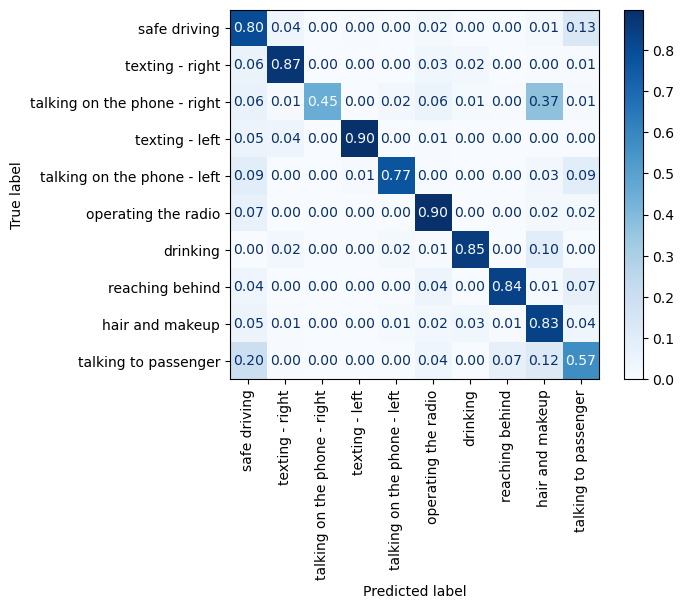

In [32]:
unpack_results(vgg16_results)

# Gradcam
##### Code by @Jacobgil [See Source here](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html)

In [43]:
# Global variables to store gradients and activations
gradients = None
activations = None

def backward_hook(module, inputs, outputs):
    global gradients
    gradients = outputs[0]  # Get the actual gradient tensor

def forward_hook(module, inputs, outputs):
    global activations
    activations = outputs
    
def grad_cam_test(model, img, layer, original_label=None, predicted_label=None, device='cpu'):
    """Function to generate Grad-CAM for a single image and a specified layer"""
    model.eval()
    img = img.to(device)

    # Register hooks on the specified layer
    layer.register_forward_hook(forward_hook)
    layer.register_full_backward_hook(backward_hook)

    # Forward pass
    with torch.enable_grad():
        img_input = img.unsqueeze(0).requires_grad_()
        prediction = model(img_input)
        prediction[:, prediction.argmax(1)].sum().backward()

        # Compute the heatmap
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(T.functional.to_pil_image(img, mode='RGB'))
        title = 'Original Image'
        if original_label is not None:
            title += f'\nTrue Label: {original_label}'
        axs[0].set_title(title)
        axs[0].axis('off')

        # Plot heatmap with adjusted parameters or different colormap
        heatmap_detached = heatmap.cpu().detach().numpy()  # Detach and move to CPU
        axs[1].imshow(heatmap_detached, cmap='jet', interpolation='nearest')
        axs[1].set_title('Heatmap')
        axs[1].axis('off')

        # Plot Grad-CAM
        overlay = T.functional.to_pil_image(heatmap.detach(), mode='F').resize(img.shape[1:3], resample=PIL.Image.BICUBIC)
        cmap = colormaps['jet']
        overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
        axs[2].imshow(T.functional.to_pil_image(img, mode='RGB'))
        axs[2].imshow(overlay, alpha=0.4, interpolation='nearest')
        title = 'Grad-CAM'
        if predicted_label is not None:
            title += f'\nPredicted Label: {predicted_label}'
        axs[2].set_title(title)
        axs[2].axis('off')

        plt.show()
        
def run_gradcam(model, layer, test_dataloader, device, num_images=10):
    # set model to eval and device
    model = model.eval()
    model = model.to(device)
    layer = layer.to(device)
    
    # Assuming test_dataloader is your DataLoader instance
    random_data = []
    for imgs, labels in test_dataloader:
        random_data.extend(zip(imgs, labels))
        if len(random_data) >= num_images:
            break
        
    # Now random_data contains at least num_images (image, label) pairs
    # We select num_images pairs randomly
    selected_data = random.sample(random_data, num_images)
    
    # Apply grad_cam_test on each of these images
    for img, original_label in selected_data:
        img, original_label = img.to(device), original_label.to(device)
        img_input = img.unsqueeze(0)
        
        with torch.no_grad():
            prediction = model(img_input.to(device))
        predicted_label = prediction.argmax(1).item()  # Assuming single output label
    
        # Convert labels to actual names if necessary, e.g., using a label map
        original_label_name = config['dataset']['class_mapping'][f'c{original_label}']  # Replace label_map with your label mapping
        predicted_label_name = config['dataset']['class_mapping'][f'c{predicted_label}'] # Replace label_map with your label mapping
    
        grad_cam_test(model, img, layer, original_label_name, predicted_label_name, device)
    

### Testing on random images in test loader

In [44]:
test_dataloader, test_data = prepare_data(img_size='L_SQUARED', shuffle=True)

In [48]:
vgg16.features[-1]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

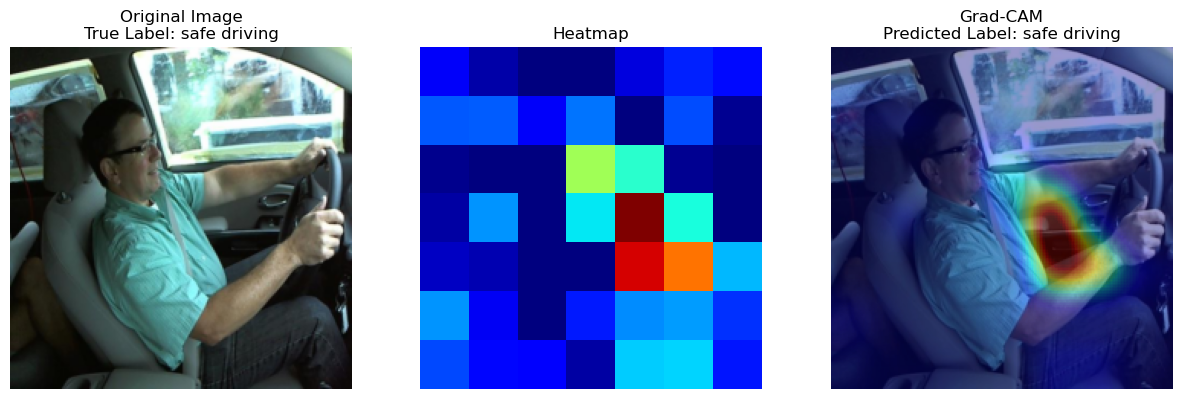

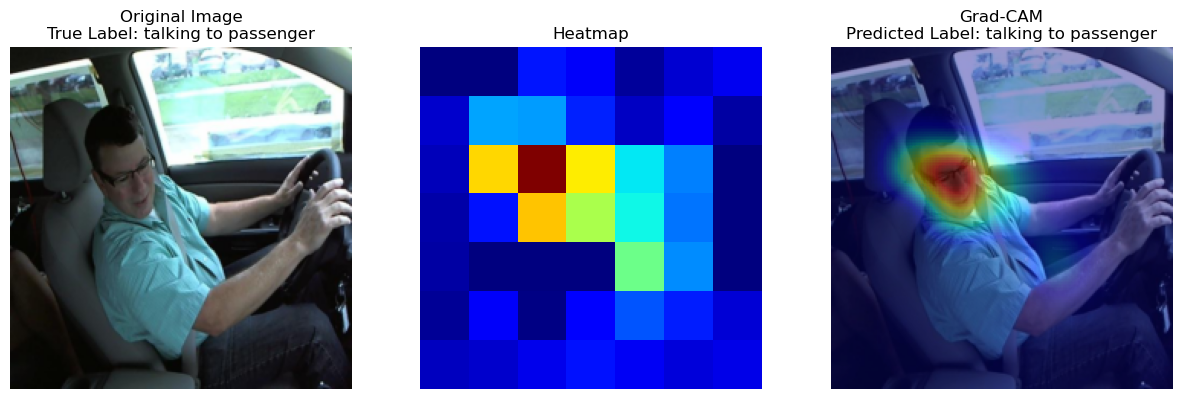

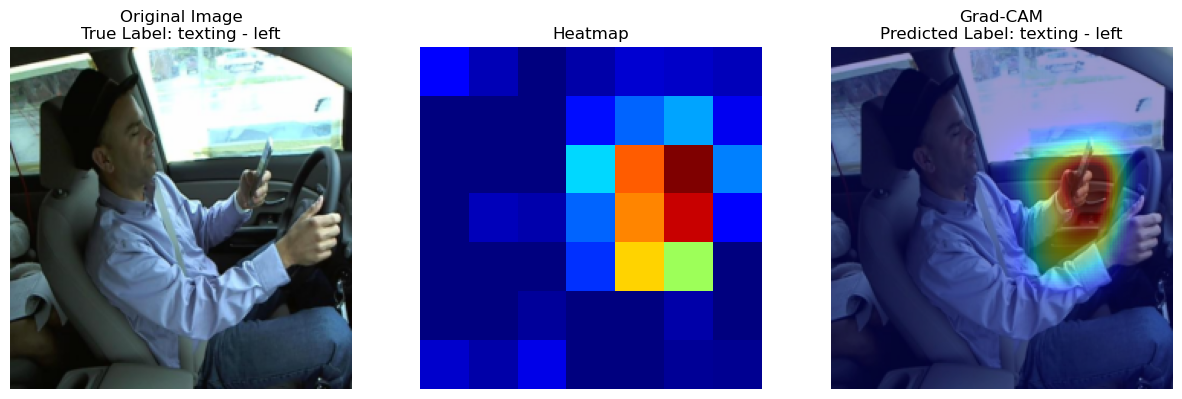

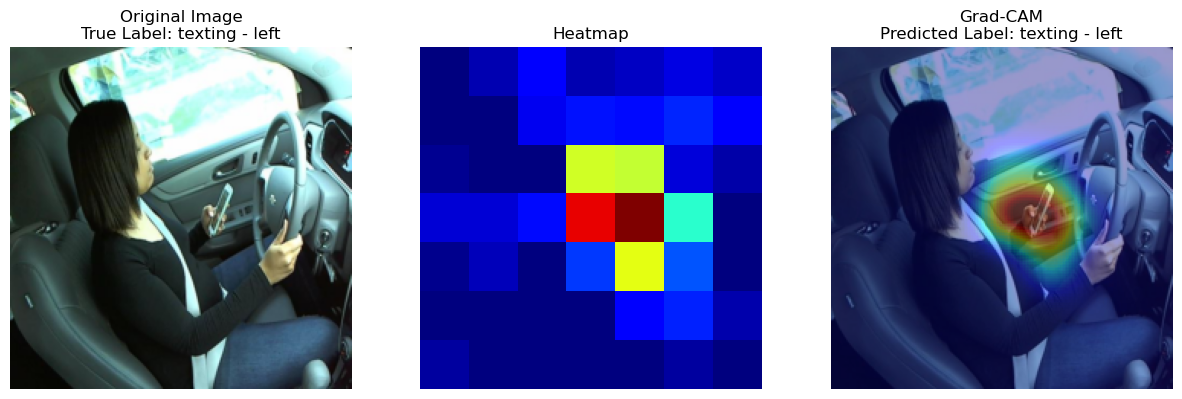

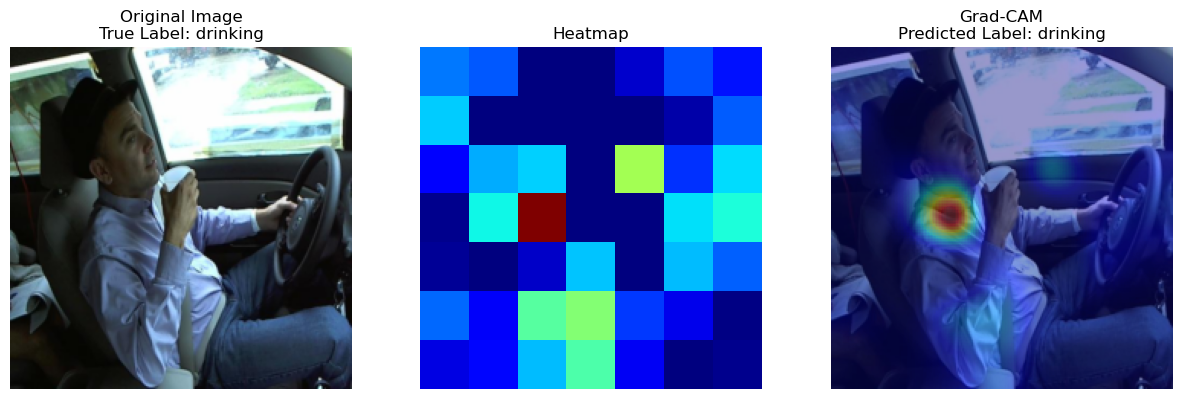

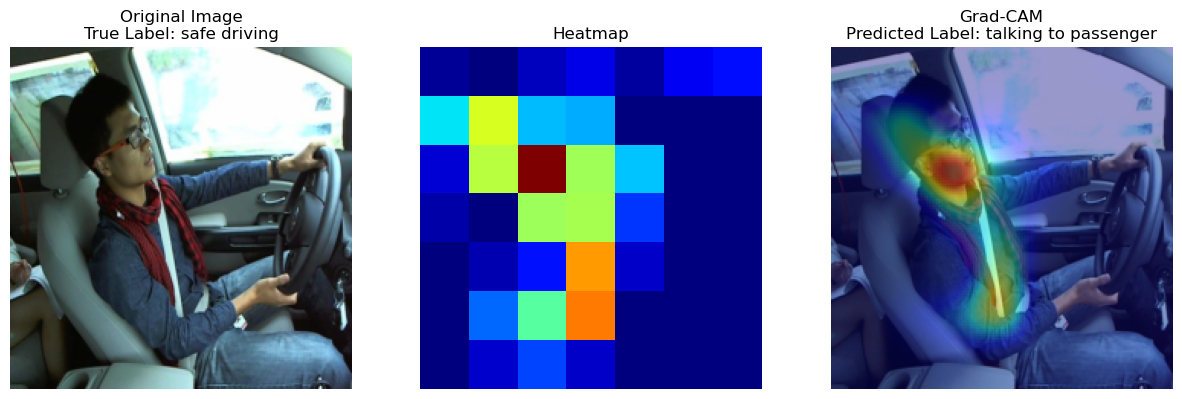

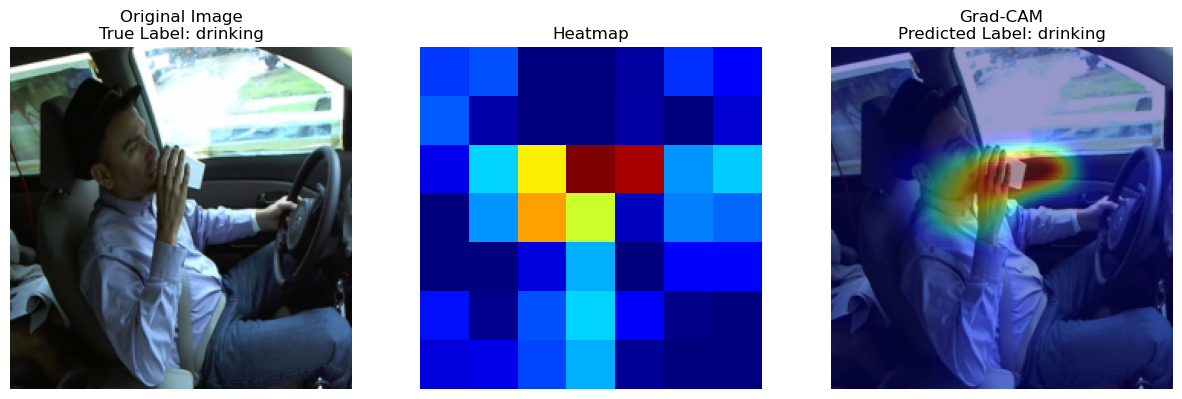

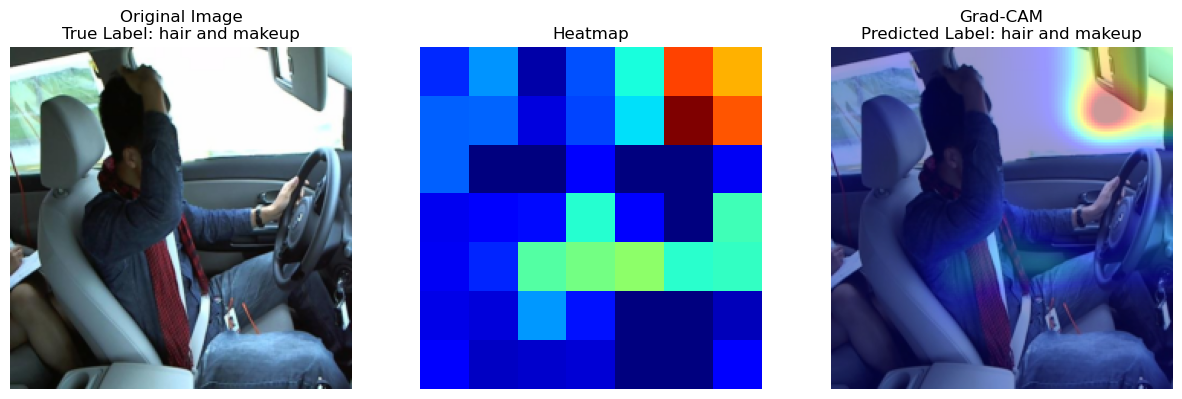

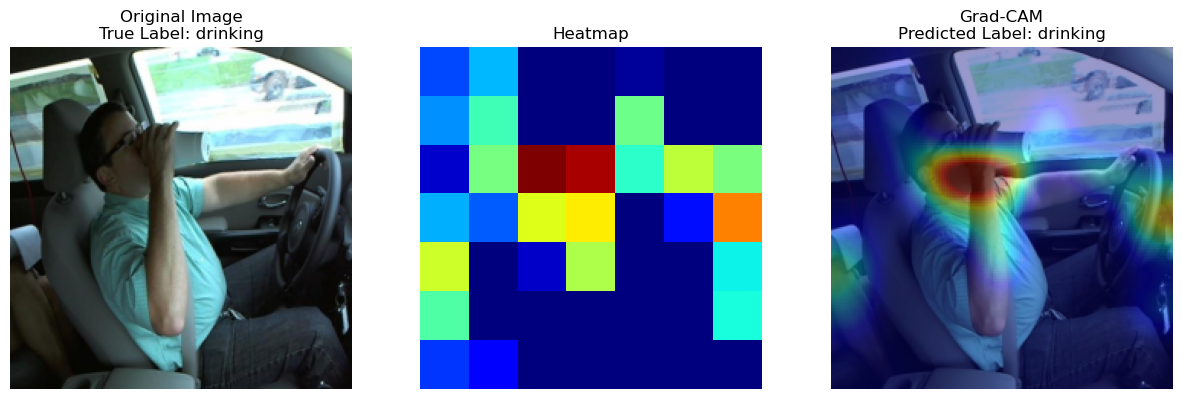

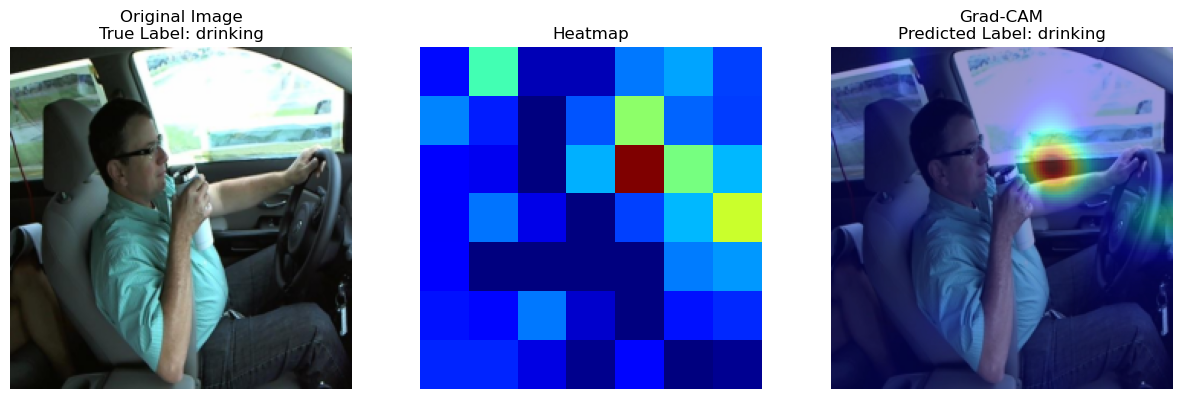

In [49]:
# Define layer to use for Grad-CAM
layer = vgg16.features[-1]#  efficient.features[-1] # nn.Sequential(efficientb1.conv_head, efficientb1.bn2)
model = vgg16

# Run Grad-CAM
run_gradcam(model, layer, test_dataloader, device, num_images=10)